<html>
    <body>
         <img src = "https://upload.wikimedia.org/wikipedia/commons/1/16/Driver_free_car.jpg" >
        <br/>
        <p>
We all know Self Driving Cars is one of the hottest areas of research and business for the tech giants. What seemed like a science-fiction, a few years ago, now seems more like  something which is soon to become a part and parcel of our regular life. Companies like Tesla, Nissan, Cadillac do have self-driving car assistance software, but, they still require a human to keep an eye on the road and take control when needed. However, it is fascinating to see how far we have come in terms of innovation and how fast technology is advancing. So much so, that now, with the help of basic deep learning, neural network magic, we can build our own pipeline for autonomous driving using Deep Learning Methodologies.</p>
        <pre>
<a id = "main"><b>Contents</b></a>
<a href = "#1"><b> - Import Packages</b></a>
<a href = "#2"><b> - Load the Training Data</b></a>
<a href = "#21"><b> - Distribution of Skewness values per column in the Dataset</b></a>
<a href = "#22"><b> - Distribution of Kurtosis values per row in the Dataset</b></a>
<a href = "#3"><b> - Create Sequential Model</b></a>
<a href = "#4"><b> - Serialize the Data</b></a>
<a href = "#5"><b> - Fit The Training Data</b></a>
<a href = "#6"><b> - Evaluating the Model Performance</b></a>
</pre>
    </body>
</html>

<b><a id = 1><pre>Import Packages</pre></a></b>

In [1]:
import numpy as np
from __future__ import division
import random
from keras.callbacks import History 
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda, Input
from keras.applications.mobilenet import MobileNet
from keras.applications import Xception
from keras.layers import MaxPooling2D, Dropout
from keras.utils import print_summary
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras import applications
from keras.optimizers import Adam
import keras.backend as K
import pickle
import csv
import cv2
import os
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
from itertools import islice
import warnings
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import load_model
import keras.utils

from keras.models import Model
from keras.applications import resnet50

#For Visualizations
from scipy.stats import norm, skew
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


<pre><b><a id = 2>Load the Training Data</b></a></pre>

In [2]:
print(os.listdir('../input'))

['train-data', 'training']


In [3]:
features_directory = '../input/training/training data/Training Data/'
labels_file = '../input/train-data/train_Data.txt'

In [4]:
def image_preprocessing(img):
    resized_image = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:, :, 1], (100, 100))
    return resized_image

In [5]:
def Load_training():
    X = []
    y = []
    features = []

    with open(labels_file) as fp:
        for line in fp:
            X.append(features_directory + line.split()[0])
            y.append(float(line.split()[1]) * scipy.pi / 180)

    for i in range(len(X)):
        img = plt.imread(X[i])
        features.append(image_preprocessing(img))
    
    return features, y

In [6]:
features, labels = Load_training()

features = np.array(features).astype('float32')
labels = np.array(labels).astype('float32')

with open("features", "wb") as f:
    pickle.dump(features, f, protocol=4)
with open("labels", "wb") as f:
    pickle.dump(labels, f, protocol=4)

In [7]:
features.shape

(15101, 100, 100)

In [8]:
labels.shape

(15101,)

<pre><b>I used Panel to convert the X and Y into Data Frames to perform 2-D Visualizations</pre></b>

In [9]:
warnings.filterwarnings('ignore')

pan = pd.Panel(features)
df = pan.swapaxes(1, 2).to_frame()
df.index = df.index.droplevel('major')
df.index = df.index+1

In [10]:
import gc
df.shape

(10000, 15101)

<pre><b><a id = 21>Distribution of Skewness values per column in the Dataset</b></a></pre>

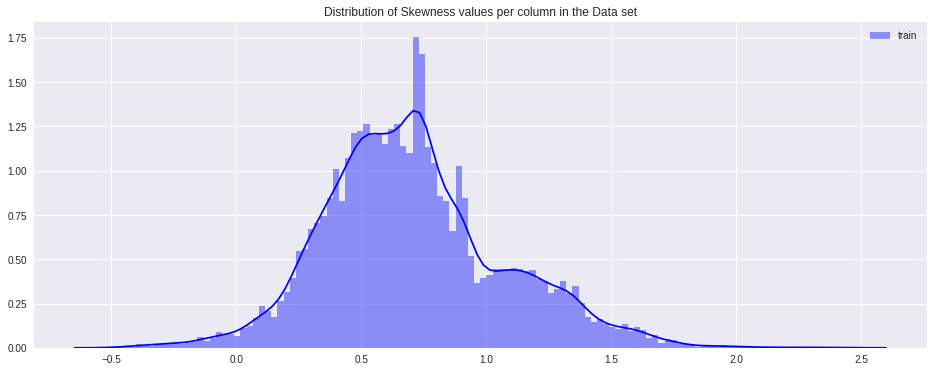

In [11]:
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=(16,6))
plt.title("Distribution of Skewness values per column in the Data set")
sns.distplot(df.skew(axis=0),color="blue", kde=True,bins=120, label='train')
plt.legend()
plt.show()

<pre><b><a id = 22>Distribution of Kurtosis values per row in the Dataset</b></a></pre>

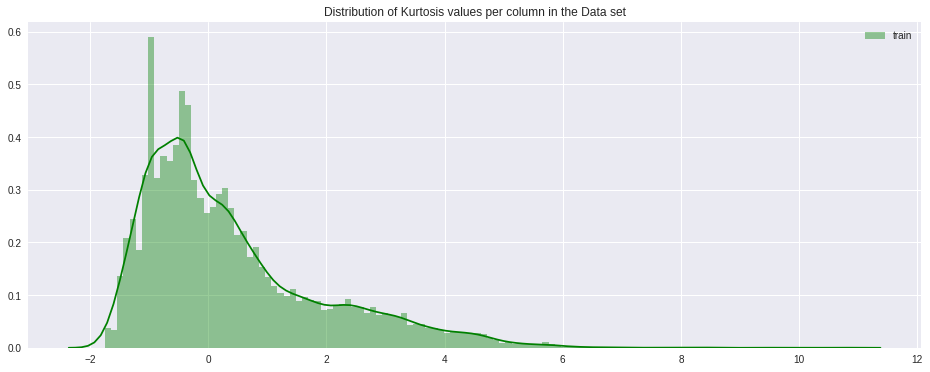

In [12]:
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=(16,6))
plt.title("Distribution of Kurtosis values per column in the Data set")
sns.distplot(df.kurtosis(axis=0),color="green", kde=True,bins=120, label='train')
plt.legend()
plt.show()

<pre><b><a id = 3>Create Sequential Model</b></a></pre>
<b><pre>We are using Transfer learning in this scenario</pre></b>

In [13]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

xception_model = Xception(include_top=False, weights= None, input_shape=(100, 100, 1))

#keeping the weights intact
for layer in xception_model.layers:
    layer.trainable = True

inputs = Input((100,100,1)) 

lambdas = Lambda(lambda x: x / 127.5 - 1.)(inputs)

outputs = xception_model(lambdas)

model = Model(inputs, outputs)

last  = model.output

x = Flatten()(last)
x = Dropout(0.5)(x)
x = Dense(10)(x)
preds = Dense(1)(x)

Revised_Model = Model(model.input, preds)
    
Revised_Model.compile(optimizer=Adam(lr=0.0001), loss="mse")
Revised_Model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 100, 1)       0         
_________________________________________________________________
xception (Model)             (None, 3, 3, 2048)        20860904  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)      

<pre><b><a id = 4>Serialize the Data</b></a></pre>

In [14]:
def loadFromPickle():
    with open("features", "rb") as f:
        features = np.array(pickle.load(f))
    with open("labels", "rb") as f:
        labels = np.array(pickle.load(f))
    return features, labels

<pre><b><a id = 5>Fit The Training Data</b></a></pre>


In [15]:
warnings.filterwarnings('ignore')

features, labels = loadFromPickle()
features, labels = shuffle(features, labels)

#do a Train Test Split
train_x, test_x, train_y, test_y = train_test_split(features, labels, random_state=42, test_size=0.20)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, random_state=42, test_size=0.10)

train_x = train_x.reshape(train_x.shape[0], 100, 100, 1)
val_x = val_x.reshape(val_x.shape[0], 100, 100, 1)

filepath = "./SelfDriving_TL.h5"

es = EarlyStopping(monitor='val_loss', verbose=1)
checkpoint = ModelCheckpoint(filepath, verbose=1,monitor='val_loss', save_best_only=True)
hist = History()
callbacks_list = [es,checkpoint,hist]
    
Revised_Model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=32,callbacks=callbacks_list)

print_summary(Revised_Model)

Revised_Model.save(filepath)

Instructions for updating:
Use tf.cast instead.
Train on 10872 samples, validate on 1208 samples
Epoch 1/10
10872/10872 [==============================] - 45s 4ms/step - loss: 0.4964 - val_loss: 0.2422

Epoch 00001: val_loss improved from inf to 0.24219, saving model to ./SelfDriving_TL.h5
Epoch 2/10
10872/10872 [==============================] - 33s 3ms/step - loss: 0.1908 - val_loss: 0.1314

Epoch 00002: val_loss improved from 0.24219 to 0.13144, saving model to ./SelfDriving_TL.h5
Epoch 3/10
10872/10872 [==============================] - 34s 3ms/step - loss: 0.1028 - val_loss: 0.1256

Epoch 00003: val_loss improved from 0.13144 to 0.12562, saving model to ./SelfDriving_TL.h5
Epoch 4/10
10872/10872 [==============================] - 33s 3ms/step - loss: 0.0751 - val_loss: 0.0945

Epoch 00004: val_loss improved from 0.12562 to 0.09452, saving model to ./SelfDriving_TL.h5
Epoch 5/10
10872/10872 [==============================] - 33s 3ms/step - loss: 0.0580 - val_loss: 0.0686

Epoch 000

<pre><b><a id = 6>Evaluating the Model Performance</b></a></pre>

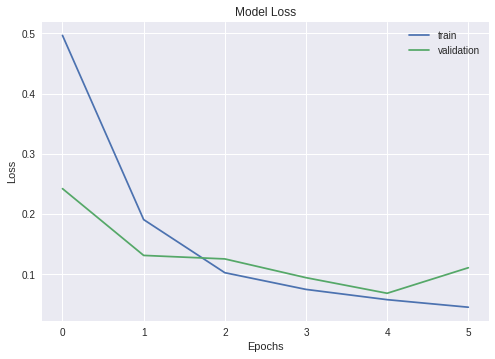

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()